# Figurative Language Alignment

## Sequence Alignment via Awesome Align

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
import itertools, copy
import torch
from matplotlib.patches import Rectangle
import seaborn as sns
%matplotlib inline

In [2]:
def run_awesome_alignment(src, tgt, model=None, tokenizer=None):
    # model parameters
    align_layer = 8
    threshold = 1e-2

    if model is None:
        model = AutoModel.from_pretrained("aneuraz/awesome-align-with-co")
    if tokenizer is None:
        tokenizer = AutoTokenizer.from_pretrained("aneuraz/awesome-align-with-co")

    # pre-processing
    sent_src, sent_tgt = src.strip().split(), tgt.strip().split()
    token_src, token_tgt = [tokenizer.tokenize(word) for word in sent_src], [tokenizer.tokenize(word) for word in
                                                               sent_tgt]
    wid_src, wid_tgt = [tokenizer.convert_tokens_to_ids(x) for x in token_src], [tokenizer.convert_tokens_to_ids(x) for
                                                                                 x in
                                                                                 token_tgt]
    ids_src, ids_tgt = tokenizer.prepare_for_model(list(itertools.chain(*wid_src)), return_tensors='pt',
                                                   model_max_length=tokenizer.model_max_length, truncation=True)[
                           'input_ids'], \
                       tokenizer.prepare_for_model(list(itertools.chain(*wid_tgt)), return_tensors='pt',
                                                   truncation=True,
                                                   model_max_length=tokenizer.model_max_length)['input_ids']
    sub2word_map_src = []
    for i, word_list in enumerate(token_src):
        sub2word_map_src += [i for x in word_list]
    sub2word_map_tgt = []
    for i, word_list in enumerate(token_tgt):
        sub2word_map_tgt += [i for x in word_list]

    # alignment
    align_layer = 8
    threshold = 1e-3
    model.eval()
    with torch.no_grad():
        out_src = model(ids_src.unsqueeze(0), output_hidden_states=True)[2][align_layer][0, 1:-1]
        out_tgt = model(ids_tgt.unsqueeze(0), output_hidden_states=True)[2][align_layer][0, 1:-1]

        dot_prod = torch.matmul(out_src, out_tgt.transpose(-1, -2))

        softmax_srctgt = torch.nn.Softmax(dim=-1)(dot_prod)
        softmax_tgtsrc = torch.nn.Softmax(dim=-2)(dot_prod)

        softmax_inter = (softmax_srctgt > threshold) * (softmax_tgtsrc > threshold)

        srctgt_sub_prob = (softmax_srctgt > threshold) * softmax_srctgt
        tgtsrc_sub_prob = (softmax_tgtsrc > threshold) * softmax_tgtsrc

        srctgt_sub_prob = srctgt_sub_prob.tolist()
        tgtsrc_sub_prob = tgtsrc_sub_prob.tolist()  # torch.transpose(tgtsrc_sub_prob, 0, 1).tolist()

    srctgt_prob = []
    tgtsrc_prob = []
    for i in range(len(sent_src)):
        sub = []
        for j in range(len(sent_tgt)):
            sub.append([])
        srctgt_prob.append(copy.deepcopy(sub))
        tgtsrc_prob.append(copy.deepcopy(sub))

    for i in range(len(srctgt_sub_prob)):
        for j in range(len(srctgt_sub_prob[0])):
            x = sub2word_map_src[i]
            y = sub2word_map_tgt[j]
            srctgt_prob[x][y].append(srctgt_sub_prob[i][j])
            tgtsrc_prob[x][y].append(tgtsrc_sub_prob[i][j])

    get_max = True
    for i in range(len(srctgt_prob)):
        for j in range(len(srctgt_prob[0])):
            probs_srctgt = srctgt_prob[i][j]
            probs_tgtsrc = tgtsrc_prob[i][j]
            if get_max:
                srctgt_prob[i][j] = max(probs_srctgt)
                tgtsrc_prob[i][j] = max(probs_tgtsrc)

    # alignment
    align_subwords = torch.nonzero(softmax_inter, as_tuple=False)
    align_words = set()
    for i, j in align_subwords:
        align_words.add((sub2word_map_src[i], sub2word_map_tgt[j]))

    return align_words, srctgt_prob, tgtsrc_prob

In [59]:
def visualize_alignment(source_sentence, tgt_sentence, alignment):
    source_len = len(source_sentence.split())
    tgt_len = len(tgt_sentence.split())
    source_nodes = ['A' + str(s1) for s1 in range(source_len)]
    gt_nodes = ['B' + str(s2) for s2 in range(tgt_len)]

    G = nx.Graph()

    edges = []
    labels_dict = {}
    nodes = []
    for s1, s2 in alignment:
        n1 = 'A' + str(s1)
        n2 = 'B' + str(s2)

        if n1 not in labels_dict:
            nodes.append(n1)
            labels_dict[n1] = source_sentence.split()[s1]

        if n2 not in labels_dict:
            nodes.append(n2)
            labels_dict[n2] = tgt_sentence.split()[s2]

        edges.append((n1, n2))

    for n in source_nodes:
        if n not in nodes:
            labels_dict[n] = source_sentence.split()[int(n[1])]

    for n in gt_nodes:
        if n not in nodes:
            labels_dict[n] = tgt_sentence.split()[int(n[1])]

    G.add_nodes_from(source_nodes, bipartite=0)  # Add the node attribute "bipartite"
    G.add_nodes_from(gt_nodes, bipartite=1)
    G.add_edges_from(edges)

    pos = dict()
    pos.update((n, (i, 2)) for i, n in enumerate(source_nodes))
    pos.update((n, (i, 1)) for i, n in enumerate(gt_nodes))
    f, ax = plt.subplots(figsize=(12, 4))
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color='white', font_weight='semibold', width=2,
                     edge_color='forestgreen', labels=labels_dict, font_size=7, ax=ax)

    plt.show()

In [82]:
def visualize_alignment_prob(probabilities, sent_tgt, sent_src, alignment, title=None):
    
    # heatmap of probabilities
    f, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(probabilities, cmap="crest", xticklabels=sent_tgt, yticklabels=sent_src, annot=True, linewidths=.5, ax=ax)
    # rectangles to highlight alignment
    for align in alignment:
        x = align[0]
        y = align[1]
        ax.add_patch(Rectangle((y, x), 1, 1, fill=False, edgecolor='orangered', lw=1.5))

    if title:
        plt.title(title)
        
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [5]:
model = AutoModel.from_pretrained("aneuraz/awesome-align-with-co")
tokenizer = AutoTokenizer.from_pretrained("aneuraz/awesome-align-with-co")

/home/kkatsy/anaconda3/envs/litmt/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertModel were not initialized from the model checkpoint at aneuraz/awesome-align-with-co and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
src = 'Hell has no fury like a woman scorned'
tgt = 'У ада нет ярости как у отвергнутой женщины'

src_list = src.strip().split()
tgt_list = tgt.strip().split()

In [7]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(src, tgt, model=model, tokenizer=tokenizer)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [8]:
align_words

{(0, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 7), (7, 6)}

In [9]:
srctgt_prob

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999998807907104, 0.0]]

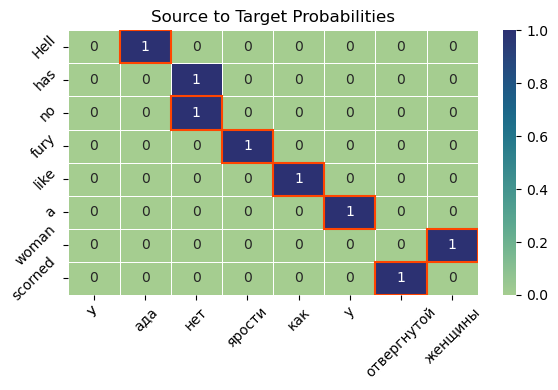

In [10]:
visualize_alignment_prob(srctgt_prob, tgt_list, src_list, align_words, title="Source to Target Probabilities")

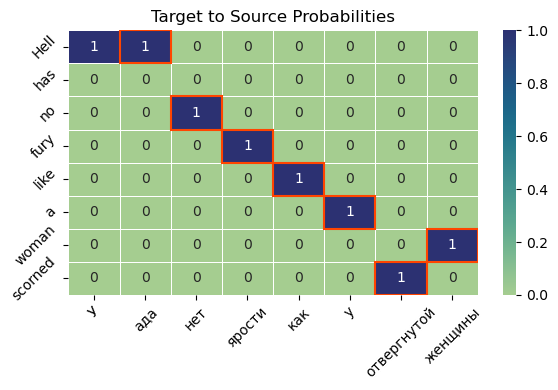

In [11]:
visualize_alignment_prob(tgtsrc_prob, tgt_list, src_list, align_words, title="Target to Source Probabilities")

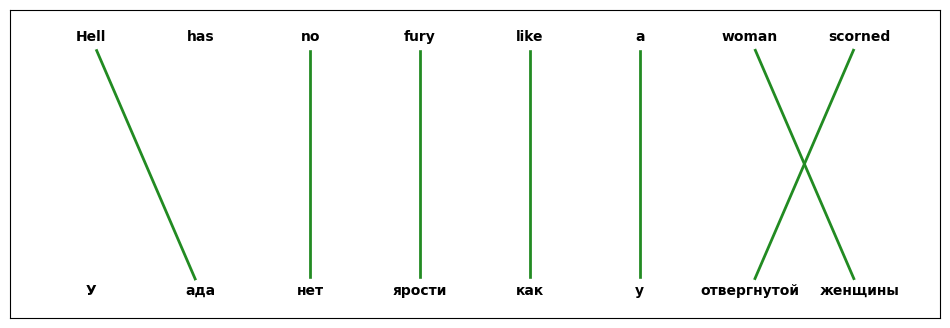

In [12]:
visualize_alignment(src, tgt, list(align_words))

## Toy Examples

In [14]:
import pickle

with open('/home/kkatsy/litMT/aligned_paragraph_dataset.pickle', 'rb') as fp:
  aligned_paragraph_dataset = pickle.load(fp)

with open('/home/kkatsy/litMT/source_paragraph_dataset.pickle', 'rb') as fp:
  source_paragraph_dataset = pickle.load(fp)

In [25]:
idx = 283
book = 'CrimeAndPunishment'
idiom = 'себя не помня'

target_keys = aligned_paragraph_dataset[book][idx]
source = source_paragraph_dataset[book][idx]

print('Source:')
print(source)
print('Translations:')
for t in target_keys:
    print(t, ': ', aligned_paragraph_dataset[book][idx][t])

Source:
Раскольников тут уже прошел и не слыхал больше. Он проходил тихо, незаметно, стараясь не проронить ни единого слова. Первоначальное изумление его мало-помалу сменилось ужасом, как будто мороз прошел по спине его. Он узнал, он вдруг, внезапно и совершенно неожиданно узнал, что завтра, ровно в семь часов вечера, Лизаветы, старухиной сестры и единственной ее сожительницы, дома не будет и что, стало быть, старуха, ровно в семь часов вечера, останется дома одна.
Translations:
Katz :  Raskolnikov passed by just then and didn't overhear any more. He walked by quietly, unnoticed, trying not to miss a single word. His initial amazement was gradually replaced by terror, as if a chill were running up and down his spine. He had found out, he had suddenly, abruptly, and completely unexpectedly found out that tomorrow, at precisely seven o'clock in the evening, Lizaveta, the old woman's sister and the only person who lived with her, would be away from home, and, as a result, the old woman, a

### Example 1

In [ ]:
idx = 283
book = 'CrimeAndPunishment'
idiom = 'мало-помалу'

target_keys = aligned_paragraph_dataset[book][idx]
source = source_paragraph_dataset[book][idx]

print('Source:')
print(source)
print('Translations:')
for t in target_keys:
    print(t, ': ', aligned_paragraph_dataset[book][idx][t])

In [67]:
id_1 = 'мало-помалу'
ru = 'Первоначальное изумление его мало-помалу сменилось ужасом, как будто мороз прошел по спине его.'
en_1 = 'His initial amazement was gradually replaced by terror, as if a chill were running up and down his spine.'
en_2 = 'His first amazement was followed by a thrill of horror, like a shiver running down his spine.'
en_3 = 'His initial amazement had little by little given way to horror, as a cold chill ran down his spine.'
en_4 = 'His initial amazement gradually gave way to horror, like a chill running down his spine.'

#### мало-помалу - little by little

In [1]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_3, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_3.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

NameError: name 'run_awesome_alignment' is not defined

#### мало-помалу - gradually

In [70]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_1, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_1.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

#### мало-помалу - null

In [72]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_2, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_2.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

### Example 2

In [ ]:
idx = 64
book = 'PoorFolk'
idiom = 'из угла в угол'

target_keys = aligned_paragraph_dataset[book][idx]
source = source_paragraph_dataset[book][idx]

print('Source:')
print(source)
print('Translations:')
for t in target_keys:
    print(t, ': ', aligned_paragraph_dataset[book][idx][t])

In [89]:
id_1 = 'из угла в угол'

ru = 'После каждого посещения батюшка делался таким недовольным, сердитым: по целым часам ходит, бывало, из угла в угол, нахмурясь, и ни с кем слова не вымолвит.'

en_1 = 'After each visit Father would become so ill-pleased and angry; I can remember that he used to pace the floor hour after hour, frowning, and never exchanging a word with anyone.'
en_2 = 'Such visits would make my father look very discontented, and seem out of temper. For hours and hours he would pace the room with a frown on his face and a brooding silence on his lips.'
en_3 = 'After every visit father was ill-humoured and cross; he would walk up and down the room by the hour together, frowning and not saying a word to anyone.'

#### из угла в угол - hours after hour

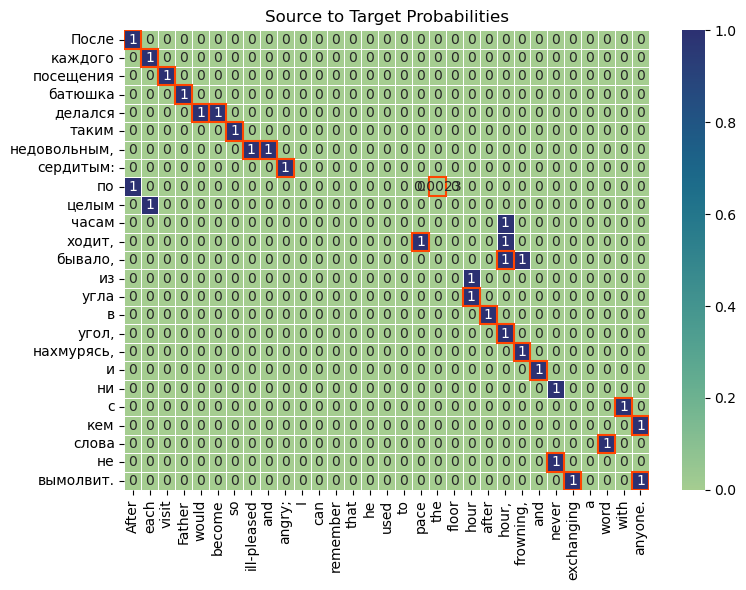

In [90]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_1, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_1.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

#### из угла в угол - null/for hours

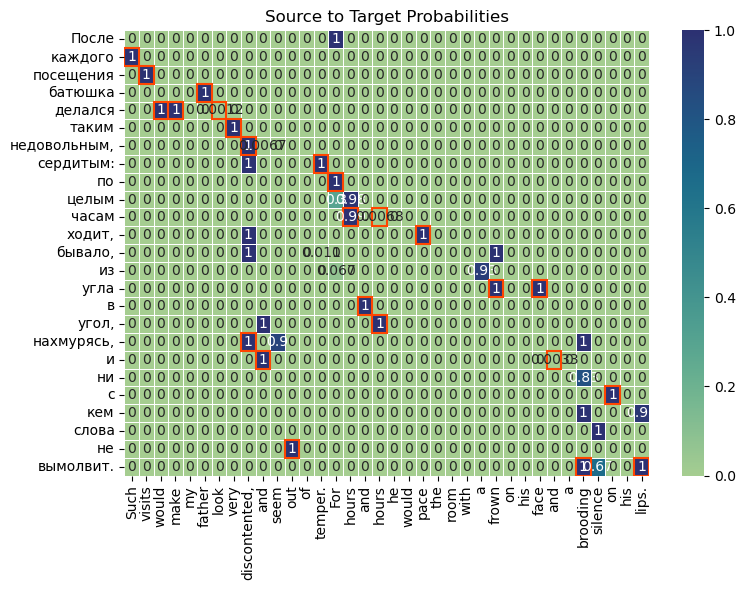

In [91]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_2, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_2.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

#### из угла в угол - up and down

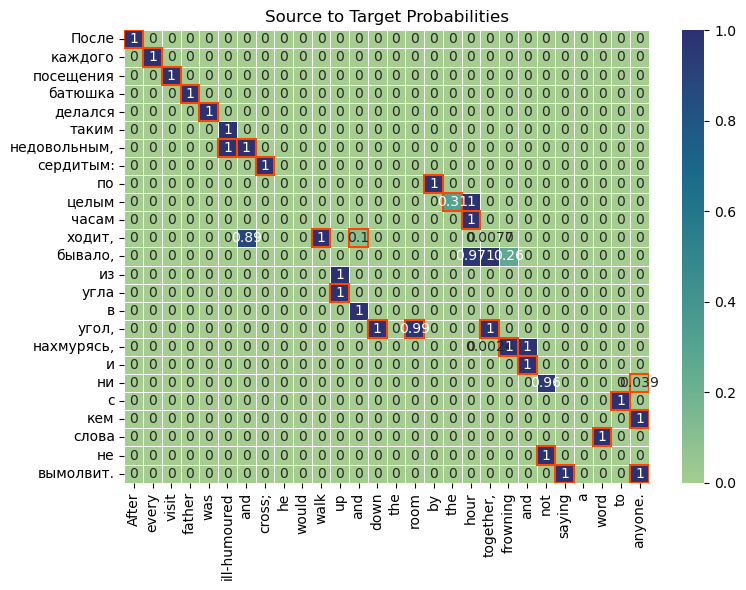

In [92]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_3, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_3.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

### Example 3

In [ ]:
idx = 283
book = 'CrimeAndPunishment'
idiom = 'себя не помня'

target_keys = aligned_paragraph_dataset[book][idx]
source = source_paragraph_dataset[book][idx]

print('Source:')
print(source)
print('Translations:')
for t in target_keys:
    print(t, ': ', aligned_paragraph_dataset[book][idx][t])

In [93]:
id_1 = 'себя не помня'

ru = '– Добивай! – кричит Миколка и вскакивает, словно себя не помня, с телеги.'

en_1 = '"Finish \'er off!" yells Mikolka, and now, as if beside himself, he jumps down from the cart.'
en_2 = '"Finish her off," shouted Mikolka and he leapt beside himself, out of the cart.'
en_3 = 'Finish her off! Mikolka shouted, leaping out of the cart as though he no longer knew what he was doing.'
en_4 = '"Give her the final one!" shouts Mikolka, and he leaps from the cart as if beside himself.'

#### себя не помня - beside himself

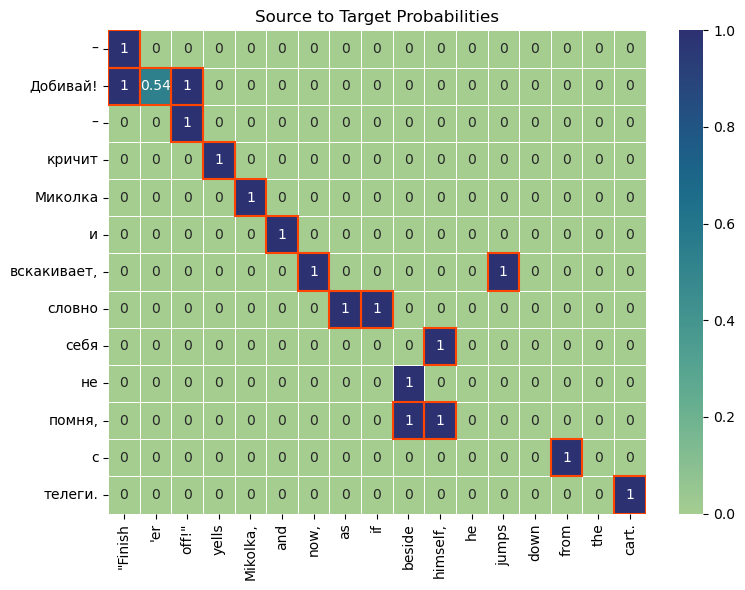

In [94]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_1, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_1.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

#### себя не помня - beside himself

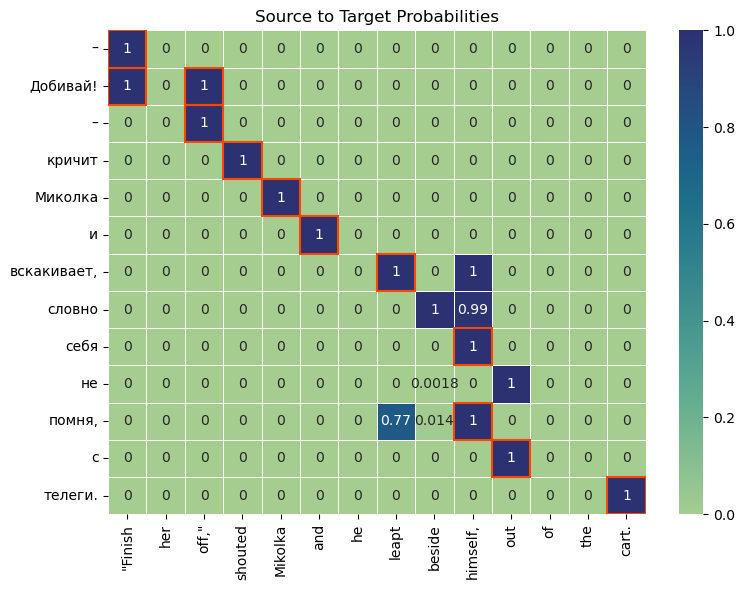

In [95]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_2, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_2.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

#### себя не помня - no longer knew what he was doing

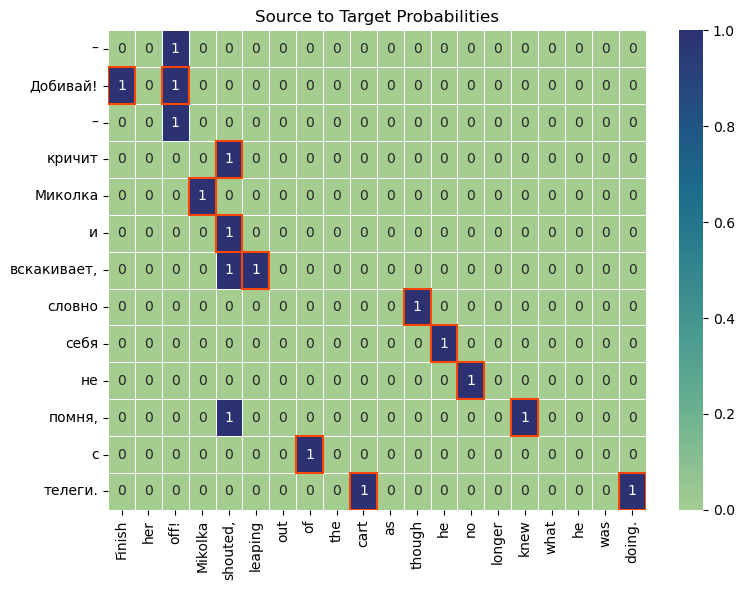

In [96]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_3, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_3.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

#### себя не помня - beside himself

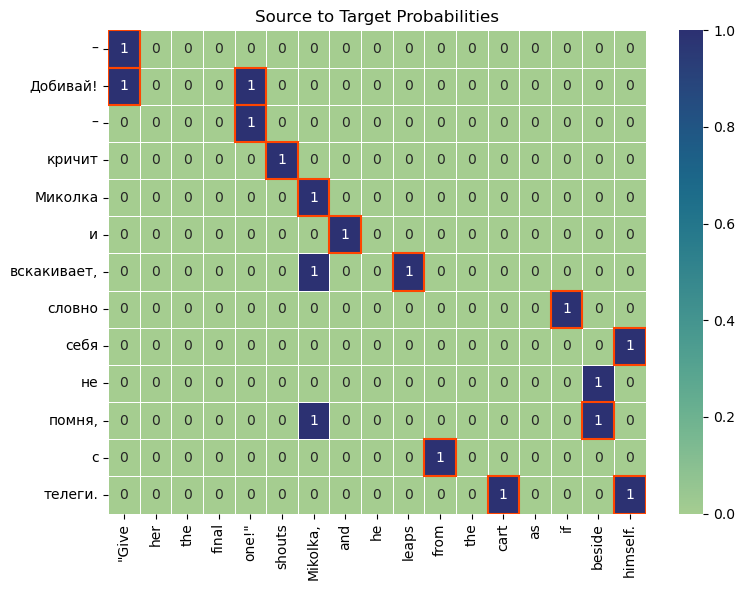

In [97]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_4, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_4.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

### Example 4

In [ ]:
idx = 2627
book = 'TheBrothersKaramazov'
idiom = 'перво-наперво'

target_keys = aligned_paragraph_dataset[book][idx]
source = source_paragraph_dataset[book][idx]

print('Source:')
print(source)
print('Translations:')
for t in target_keys:
    print(t, ': ', aligned_paragraph_dataset[book][idx][t])

In [98]:
id_1 = 'перво-наперво'
id_2 = 'глазком глянуть'

ru = 'Теперь, Трифон Борисыч, проводи меня тихо и дай мне на них на всех перво-наперво глазком глянуть, так чтоб они меня не заметили.'

en_1 = 'Now then, Trifon Borisych, take me up there quietly and let me first of all get an eyeful of them, but so that they don\'t notice me'
en_2 = 'Now, Trifon Borisych, lead me up there quietly, and let me take a good look at them, so they don\'t see me'
en_3 = 'Now, Trifon Borissovitch, take me up quietly and let me first get a look at them, so that they don\'t see me'
en_4 = 'Now, Trifon Borisich, take me in quietly and let me first have a look at them all, so that they don\'t notice me'

#### перво-наперво - first of all, глазком глянуть - get an eyeful

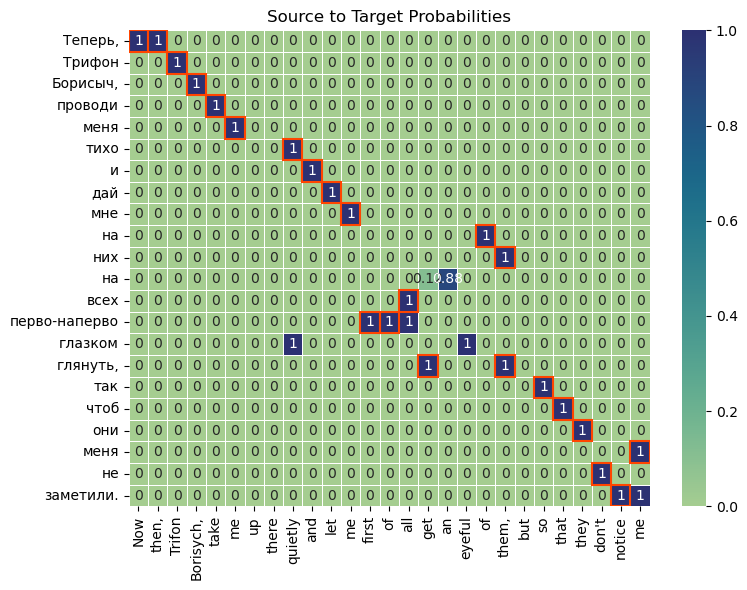

In [99]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_1, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_1.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

#### перво-наперво - null, глазком глянуть - take a good look

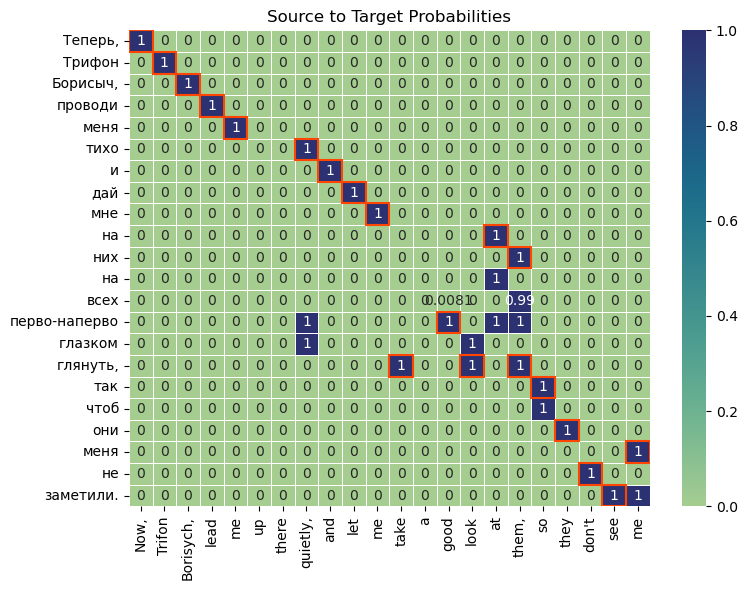

In [100]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_2, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_2.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

#### перво-наперво - first, глазком глянуть - get a look

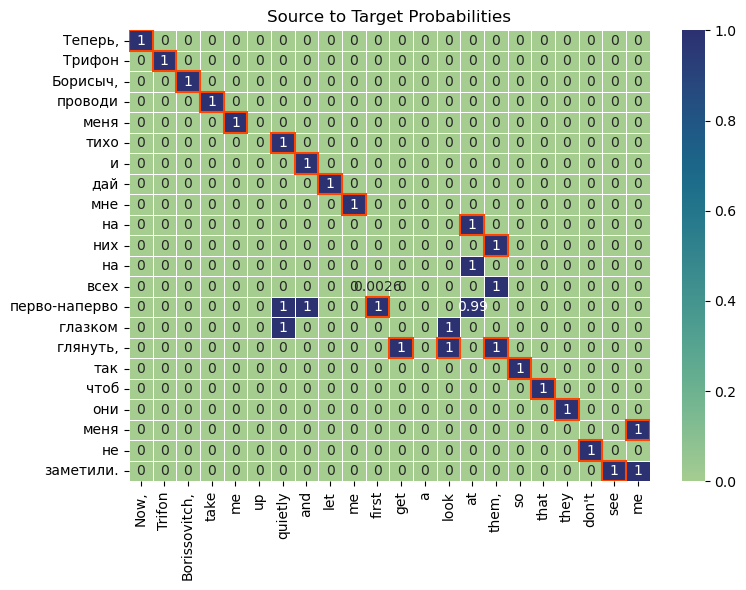

In [101]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_3, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_3.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

#### перво-наперво - first, глазком глянуть - have a look

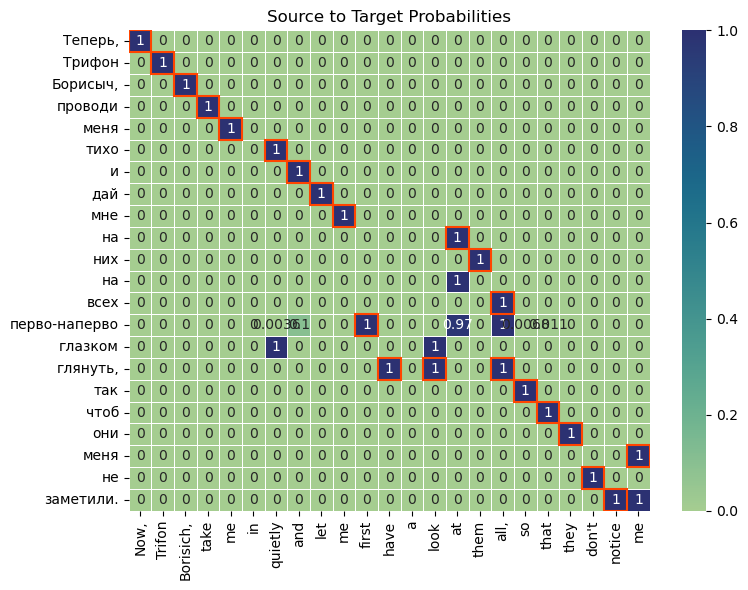

In [102]:
align_words, srctgt_prob, tgtsrc_prob = run_awesome_alignment(ru, en_4, model=model, tokenizer=tokenizer)
visualize_alignment_prob(srctgt_prob, en_4.strip().split(), ru.strip().split(), align_words, title="Source to Target Probabilities")

### Idiom to Idiom

### Idiom to Paraphrase

### Phrase to Idiom

### Idiom to None